In [1]:
import torch 
import pandas as pd 
import numpy as np
import os
from lincs_gsnn.data.DXDTDataset import DXDTDataset
from torch.utils.data import DataLoader 

from lincs_gsnn.models.SplineWeightEmbedding import SplineWeightEmbedding

from matplotlib import pyplot as plt
import seaborn as sbn
from sklearn.metrics import r2_score

import networkx as nx 
import pickle as pkl

from pypath.utils import mapping
import warnings 

from pypath.utils import mapping

warnings.filterwarnings("ignore")

from lincs_gsnn.models.ODEFunc import ODEFunc
from lincs_gsnn.data.TrajDataset import TrajDataset
from torchdiffeq import odeint 

import gseapy as gp
from lincs_gsnn.explain.viz import annotate_edges, get_drug_edges, make_subgraph, plot_graph, axes_to_gif

from lincs_gsnn.explain.infer_edge_weights import infer_edge_weights

import statsmodels.api as sm

%load_ext autoreload
%autoreload 2

In [2]:
data = torch.load('/home/teddy/local/lincs-gsnn/workflow/runs/default/bionetwork/bionetwork.pt', weights_only=False)
model = torch.load('../workflow/runs/default/pretrain/pretrained_model.pt', weights_only=False)
dxdt_scale = torch.load('../workflow/runs/default/pretrain/dxdt_scale.pt', weights_only=False).item()
x_names = pd.read_csv('/home/teddy/local/lincs-traj/workflow/runs/exp/default_v02/output/predict_grid/gene_names.csv')['gene_names'].values.astype(str)
dxdt_meta = pd.read_csv('/home/teddy/local/lincs-traj/workflow/runs/exp/default_v02/output/predict_grid/dxdt_meta.csv')

In [3]:
cellinfo_linc = pd.read_csv('../../data/cellinfo_beta.txt', sep='\t')[['cell_iname', 'ccle_name']]
cellinfo_ccle = pd.read_csv('../../data/DepMap-2019q1-celllines_v2.csv')[['DepMap_ID', 'CCLE_Name']]
cellinfo_linc.rename(columns={'ccle_name': 'CCLE_Name'}, inplace=True) 
cellinfo = cellinfo_linc.merge(cellinfo_ccle, on='CCLE_Name', how='inner')
cellinfo.head()

,cell_iname,CCLE_Name,DepMap_ID
0,OCILY10,OCILY10_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-001146
1,TC32,TC32_BONE,ACH-001205
2,HCC515,HCC515_LUNG,ACH-000872
3,SALE,SALE_LUNG,ACH-000064
4,SHSY5Y,SHSY5Y_AUTONOMIC_GANGLIA,ACH-001188


In [12]:
obs_dir = '/home/teddy/local/lincs-traj/workflow/runs/exp/default_v02/output/predict_grid/dxdt/'
drug = 'BRD-K49328571'

res_dict = {} 
for cell in dxdt_meta.cell_iname.unique():
    print(f'VVV --- running... {cell} --- VVV')
    cond_cell1 = dxdt_meta[lambda x: (x.cell_iname == cell) & (x.pert_id == 'BRD-K49328571') & (x.dose == 0.1)]
    wt, SWE, metrics = infer_edge_weights(model, data, cond_cell1, x_names, obs_dir, dxdt_scale, 
                                            n_ctrl_pts=5, degree=3, prior=0, lr=1e-2, beta=5e-4, 
                                            epochs=500, batch_size=600, num_workers=2, dropout=0.05) 
    res_dict[cell] = {'wt': wt, 'SWE': SWE, 'metrics': metrics}
    print() 

VVV --- running... HME1 --- VVV
Epoch 499, norm: 606.4184, mse: 0.0497, r2: 0.8697
VVV --- running... BT20 --- VVV
Epoch 499, norm: 566.9213, mse: 0.0340, r2: 0.8783
VVV --- running... BT474 --- VVV
Epoch 499, norm: 630.1412, mse: 0.0614, r2: 0.8879
VVV --- running... HS578T --- VVV
Epoch 499, norm: 585.7807, mse: 0.0403, r2: 0.8532
VVV --- running... MCF10A --- VVV
Epoch 499, norm: 500.5601, mse: 0.0257, r2: 0.8122
VVV --- running... MCF7 --- VVV
Epoch 499, norm: 363.1864, mse: 0.0220, r2: 0.21856
VVV --- running... MDAMB231 --- VVV
Epoch 499, norm: 615.3376, mse: 0.0413, r2: 0.8638
VVV --- running... MDAMB468 --- VVV
Epoch 499, norm: 630.1013, mse: 0.0704, r2: 0.8911
VVV --- running... SKBR3 --- VVV
Epoch 499, norm: 464.1918, mse: 0.0255, r2: 0.7613
VVV --- running... T47D --- VVV
Epoch 499, norm: 583.4575, mse: 0.0459, r2: 0.8921
VVV --- running... ZR751 --- VVV
Epoch 499, norm: 686.7479, mse: 0.0750, r2: 0.9062


In [13]:
W = np.stack([res_dict[cell]['wt'].max(axis=0) for cell in dxdt_meta.cell_iname.unique()])
W.shape

(11, 42564)

In [14]:
prot_space_uni = np.unique([x.split('__')[1] for x in data.node_names_dict['function'] if x.split('__')[0] == 'PROTEIN'])

In [19]:
mut = pd.read_csv('../../data/OmicsSomaticMutations.csv')[['ModelID', 'VariantType', 'ProteinChange', 'HugoSymbol',  'UniprotID', 'LofGeneName', 'MolecularConsequence','Sift','Polyphen' , 'Rescue', 'RescueReason']]
mut = mut.merge(cellinfo, left_on='ModelID', right_on='DepMap_ID', how='inner')
mut = mut[lambda x: x.cell_iname.isin(dxdt_meta.cell_iname.unique())]
mut.UniprotID = mut.UniprotID.fillna('')
mut = mut.assign(uniprot_id = [x.split('-')[0] for x in mut.UniprotID]) 

In [23]:
mut = mut[mut.uniprot_id.isin(prot_space_uni)] 
mut.Polyphen = mut.Polyphen.fillna('')
mut = mut[lambda x: x.Polyphen.str.contains('probably_damaging')]
mut.head(25) [['HugoSymbol', 'uniprot_id', 'Sift', 'Polyphen', 'cell_iname']]

,HugoSymbol,uniprot_id,Sift,Polyphen,cell_iname
2239,TNNI3K,Q59H18,deleterious(0),probably_damaging(0.987),BT474
12460,KMT2A,Q03164,deleterious_low_confidence(0),probably_damaging(0.99),BT474
14698,ERBB3,P21860,deleterious(0),probably_damaging(0.998),SKBR3
23640,NFATC3,Q12968,deleterious(0),probably_damaging(0.994),BT20
26080,STAT3,P40763,deleterious_low_confidence(0.01),probably_damaging(0.967),BT474
31034,PAK4,O96013,deleterious(0),probably_damaging(0.939),BT474
37128,ERBB4,Q15303,deleterious_low_confidence(0),probably_damaging(0.994),MCF7
45992,PDGFRA,P16234,deleterious(0.02),probably_damaging(0.996),MDAMB231
52308,SRPK1,Q96SB4,deleterious(0),probably_damaging(0.998),SKBR3
54927,ETV1,P50549,deleterious(0),probably_damaging(0.992),SKBR3


In [24]:
rows = dxdt_meta.cell_iname.unique().tolist() 
cols = [f'{x}->{y}' for x, y in zip(np.array(model.homo_names)[model.edge_index[:, model.function_edge_mask][0].cpu()], 
                                     np.array(model.homo_names)[model.edge_index[:, model.function_edge_mask][1].cpu()])]
Wdf = pd.DataFrame(W[:, model.function_edge_mask.cpu()], columns = cols, index=rows)
Wdf.head() 



,PROTEIN__P01106->RNA__O14746,PROTEIN__P05412->RNA__P84022,PROTEIN__P84022->RNA__P05412,PROTEIN__Q13485->RNA__P05412,PROTEIN__Q04206->RNA__P25445,PROTEIN__P08047->RNA__P04075,PROTEIN__P04637->RNA__P08069,PROTEIN__Q05516->RNA__P20248,PROTEIN__P42224->RNA__P38936,PROTEIN__P40763->RNA__P38936,...,RNA__Q9Y644->RNA__Q9Y644,RNA__Q9Y653->RNA__Q9Y653,RNA__Q9Y696->RNA__Q9Y696,RNA__Q9Y6E2->RNA__Q9Y6E2,RNA__Q9Y6K1->RNA__Q9Y6K1,RNA__Q9Y6M1->RNA__Q9Y6M1,RNA__Q9Y6N5->RNA__Q9Y6N5,RNA__Q9Y6P5->RNA__Q9Y6P5,RNA__Q9Y6Q9->RNA__Q9Y6Q9,RNA__Q9Y6R4->RNA__Q9Y6R4
HME1,0.411496,0.496912,0.368046,0.642570,0.847672,0.235934,0.095394,0.738421,0.786047,0.815198,...,0.122857,0.134483,0.423469,0.298867,0.451807,0.208361,0.510797,0.833549,0.149883,0.357922
BT20,0.180190,0.584897,0.372774,0.905340,0.721049,0.096250,0.092071,0.152924,0.874104,0.694944,...,0.436701,0.544380,0.100725,0.588568,0.093441,0.154958,0.552780,0.871229,0.113695,0.215906
BT474,0.623803,0.115704,0.573507,0.914151,0.147924,0.089353,0.113123,0.105370,0.437247,0.669748,...,0.767313,0.324608,0.748374,0.617783,0.846304,0.175500,0.325287,0.273587,0.134378,0.495264
HS578T,0.160313,0.845666,0.085310,0.910791,0.340922,0.100121,0.831946,0.125620,0.659293,0.743012,...,0.359143,0.131400,0.159582,0.475051,0.721924,0.230486,0.423659,0.819303,0.668887,0.558222
MCF10A,0.260232,0.877757,0.156939,0.561423,0.141204,0.089780,0.084561,0.113131,0.317168,0.244662,...,0.637355,0.547384,0.165261,0.723668,0.089703,0.291752,0.439471,0.826757,0.094019,0.293327


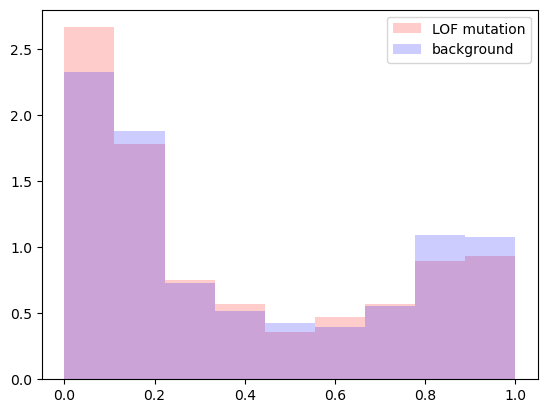

In [26]:
mut_weights = [] 
background_weights = [] 

for i,row in mut.iterrows(): 
    
    prot = f'PROTEIN__{row.uniprot_id}'
    cell = row.cell_iname

    mut_edge_mask = [prot in x for x in Wdf.columns] # Q12968 (damaging) - BT20
    mut_cell_mask = Wdf.index == cell

    mut_edges = Wdf[mut_cell_mask].values[:, mut_edge_mask]
    background_edges = Wdf[~mut_cell_mask].values[:, mut_edge_mask]
    mut_weights += mut_edges.ravel().tolist() 
    background_weights += background_edges.ravel().tolist() 

    '''plt.figure() 
    plt.hist(mut_edges.ravel(), np.linspace(0,1,10), color='r', label=f'LOF mutation ({cell}, {row.HugoSymbol})', alpha=0.2, density=True)
    plt.hist(background_edges.ravel(), np.linspace(0,1,10), color='b', label='background', alpha=0.2, density=True)
    plt.legend() 
    plt.show() '''

plt.figure() 
plt.hist(mut_weights, np.linspace(0,1,10), color='r', label=f'LOF mutation', alpha=0.2, density=True)
plt.hist(background_weights, np.linspace(0,1,10), color='b', label='background', alpha=0.2, density=True)
plt.legend() 
plt.show() 



In [145]:
mut_edges = Wdf[mut_cell_mask].values[:, mut_edge_mask]
background_edges = Wdf[~mut_cell_mask].values[:, mut_edge_mask]

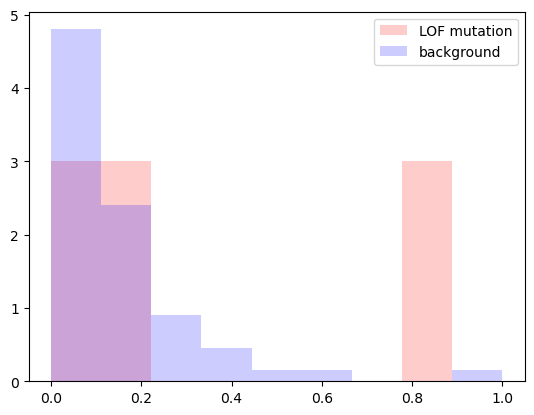

In [147]:
plt.figure() 
plt.hist(mut_edges.ravel(), np.linspace(0,1,10), color='r', label='LOF mutation', alpha=0.2, density=True)
plt.hist(background_edges.ravel(), np.linspace(0,1,10), color='b', label='background', alpha=0.2, density=True)
plt.legend() 
plt.show() 

In [ ]:
res = pd.DataFrame({'src': np.array(model.homo_names)[model.edge_index[:, model.function_edge_mask][0].cpu()],
                     'dst': np.array(model.homo_names)[model.edge_index[:, model.function_edge_mask][1].cpu()],
                     'weight': edge_weight[model.function_edge_mask.cpu()]})

0.46715692109732976

In [ ]:
# General idea, run same condition on all cell lines, find baseline distribution of edge weights, then compare the edge weights from 
# deleterious mutations (e.g., TP53 -> any, if TP53 is mutated). Expectation is that edges from mutated/non-functional proteins will 
# have lower weights than edges from functional proteins (as compared to the baseline distribution). 

# is there a better datatype for this? protein expression? metabolomics? methylation? 

# could also consider doing this with miRNAs... if a miRNA is mutated (especially if its commonly mutated in cancers), then it's likely 
# that the miRNA  is not functional and would show up as not being active in the network. I wonder if we could find an example of this? 



In [ ]:
edge_mask = (wt > 0.5).any(axis=0)
res = annotate_edges(model, edge_mask) 
drug_edges = get_drug_edges(data, drug=drug) 
G = make_subgraph(data, res, drug_edges) 

In [ ]:
H = nx.convert_node_labels_to_integers(G, label_attribute="node_label")
H_layout = nx.nx_pydot.pydot_layout(H, prog="dot")
pos = {H.nodes[n]["node_label"]: p for n, p in H_layout.items()}

f, ax = plot_graph(G, pos=pos)